# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per capita (by Census Tract) 

### BROOKLYN

In [3]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [4]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [4]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [5]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [6]:
# look at only Brooklyn
BK_trees_cap = trees_cts.query("county == 'Kings'")

[Text(0.5, 1.0, 'Brooklyn')]

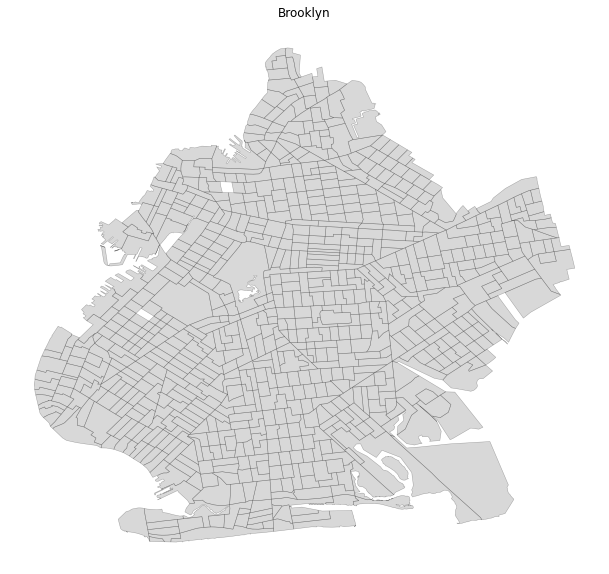

In [7]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Brooklyn')

In [7]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
BK_trees_cap = BK_trees_cap.dropna(subset = ['trees_per_capita'])

In [8]:
# drop trees per capita with 0
BK_trees_cap = BK_trees_cap.query("trees_per_capita > 0")

In [9]:
# create queen contiguity weights
w_BK = weights.Queen.from_dataframe(BK_trees_cap)

In [12]:
# fill in islands with KNN weights
w_knn_BK = weights.KNN.from_dataframe(BK_trees_cap, k=1)

In [13]:
w_BK = weights.attach_islands(w_BK, w_knn_BK)

There are no disconnected observations (no islands)!


In [14]:
# row standardize weights
w_BK.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [15]:
# on trees per capita
local_moran_BK = esda.moran.Moran_Local(BK_trees_cap['trees_per_capita'], w_BK)

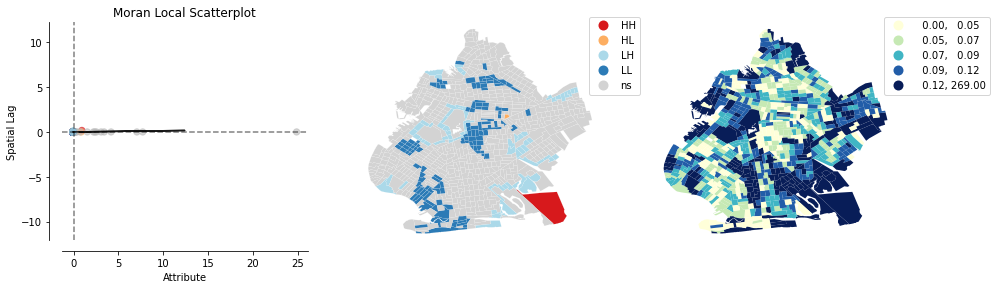

In [51]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK, BK_trees_cap,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita_moran.pdf")

In [17]:
# get clusters and outliers - adding columns to the DF

BK_trees_cap['local_moran_Is'] = local_moran_BK.Is
BK_trees_cap['local_moran_p_value'] = local_moran_BK.p_sim
BK_trees_cap['local_moran_quadrant'] = local_moran_BK.q

In [18]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_BK = BK_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK = BK_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK = BK_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK = BK_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

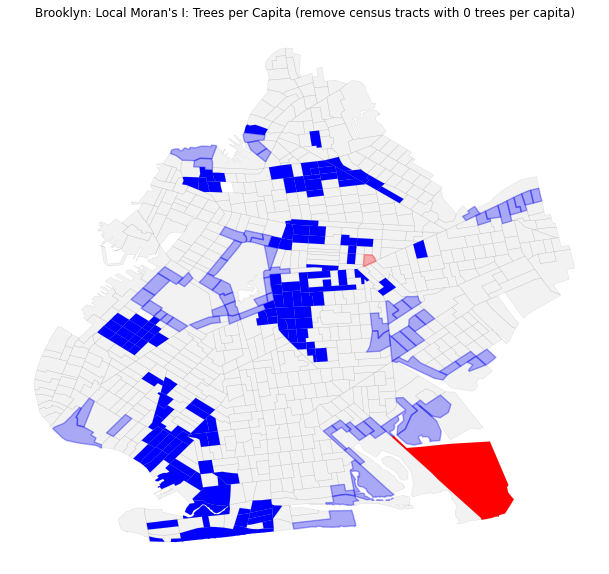

In [19]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per capita)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita.pdf")

### *investigate the numbers*

In [18]:
# look at smallest values
BK_trees_cap['trees_per_capita'].nsmallest(n=10)

274     0.001930
38      0.002771
561     0.002826
1505    0.003487
1186    0.005072
2010    0.005172
492     0.006207
760     0.009316
328     0.010543
365     0.011241
Name: trees_per_capita, dtype: float64

In [19]:
# look at largest values
BK_trees_cap['trees_per_capita'].nlargest(n=10)

1287    269.000000
1819     84.000000
1010     77.000000
2239     46.000000
1009     37.666667
1554     34.000000
1398     28.333333
2054     26.500000
1742     24.875000
1938     17.333333
Name: trees_per_capita, dtype: float64

In [22]:
# lowest 1% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.01))

0.010432135065885563


In [23]:
# lowest 5% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.05))

0.029606636805187908


In [24]:
# lowest 10% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.10))

0.04195633745329719


In [25]:
# lowest 20% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.20))

0.052933376939126815


In [26]:
# highest 1% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.99))

25.02125000000005


In [27]:
# highest 5% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.95))

0.23350279048221226


In [28]:
# highest 10% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.90))

0.16868645085745104


In [29]:
# highest 20% of data
print(BK_trees_cap['trees_per_capita'].quantile(q = 0.80))

0.11795320358626725


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 0.1 and more than 10  trees per capita*

In [30]:
# limit the range
BK_trees_cap_limit = BK_trees_cap.query("trees_per_capita > 0.01 & trees_per_capita < 10")

In [31]:
# create queen contiguity weights
w_BK2 = weights.Queen.from_dataframe(BK_trees_cap_limit)

In [33]:
# fill in islands with KNN weights
w_knn_BK2 = weights.KNN.from_dataframe(BK_trees_cap_limit, k=1)

In [34]:
w_BK2 = weights.attach_islands(w_BK2, w_knn_BK2)

There are no disconnected observations (no islands)!


In [35]:
# row standardize weights
w_BK2.transform = 'R'

In [36]:
# on trees per capita
local_moran_BK2 = esda.moran.Moran_Local(BK_trees_cap_limit['trees_per_capita'], w_BK2)

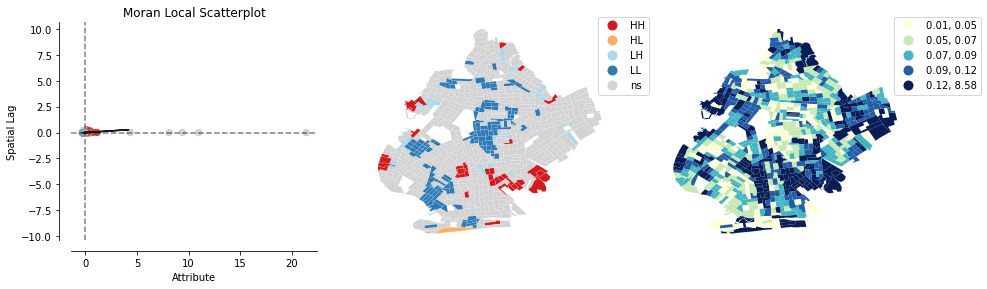

In [50]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK2, BK_trees_cap_limit,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita_limited_moran.pdf")

In [39]:
# get clusters and outliers
BK_trees_cap_limit['local_moran_Is'] = local_moran_BK2.Is
BK_trees_cap_limit['local_moran_p_value'] = local_moran_BK2.p_sim
BK_trees_cap_limit['local_moran_quadrant'] = local_moran_BK2.q

In [40]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BK2 = BK_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK2 = BK_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK2 = BK_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK2 = BK_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

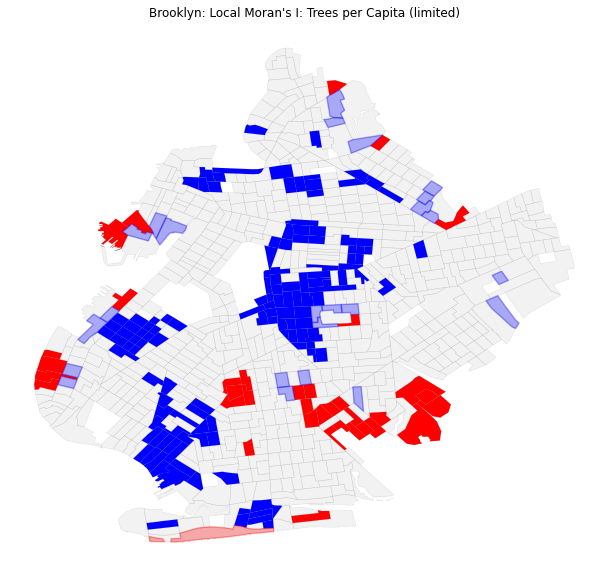

In [41]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 0.1 and more than 1  trees per capita*

In [45]:
# limit the range
BK_trees_cap_limit_more = BK_trees_cap.query("trees_per_capita > 0.01 & trees_per_capita < 1")

In [46]:
# create queen contiguity weights
w_BK3 = weights.Queen.from_dataframe(BK_trees_cap_limit_more)

In [48]:
# fill in islands with KNN weights
w_knn_BK3 = weights.KNN.from_dataframe(BK_trees_cap_limit_more, k=1)

In [41]:
w_BK3 = weights.attach_islands(w_BK3, w_knn_BK3)

There are no disconnected observations (no islands)!


In [42]:
# row standardize weights
w_BK3.transform = 'R'

In [43]:
# on trees per capita
local_moran_BK3 = esda.moran.Moran_Local(BK_trees_cap_limit_more['trees_per_capita'], w_BK3)

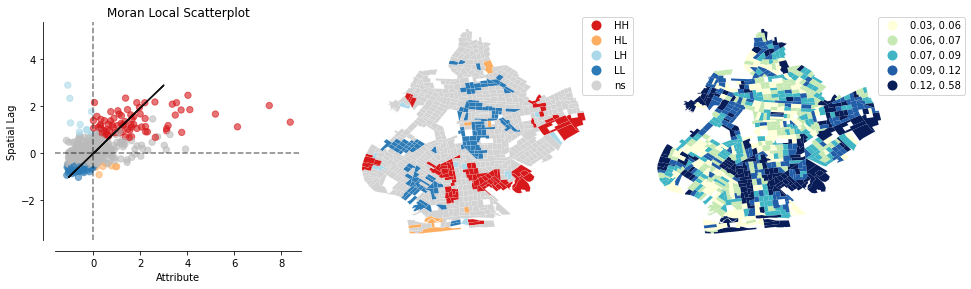

In [44]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK3, BK_trees_cap_limit_more,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita_more-limited_moran.pdf")

In [27]:
# get clusters and outliers
BK_trees_cap_limit_more['local_moran_Is'] = local_moran_BK3.Is
BK_trees_cap_limit_more['local_moran_p_value'] = local_moran_BK3.p_sim
BK_trees_cap_limit_more['local_moran_quadrant'] = local_moran_BK3.q

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is tryin

In [28]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BK3 = BK_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK3 = BK_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK3 = BK_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK3 = BK_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

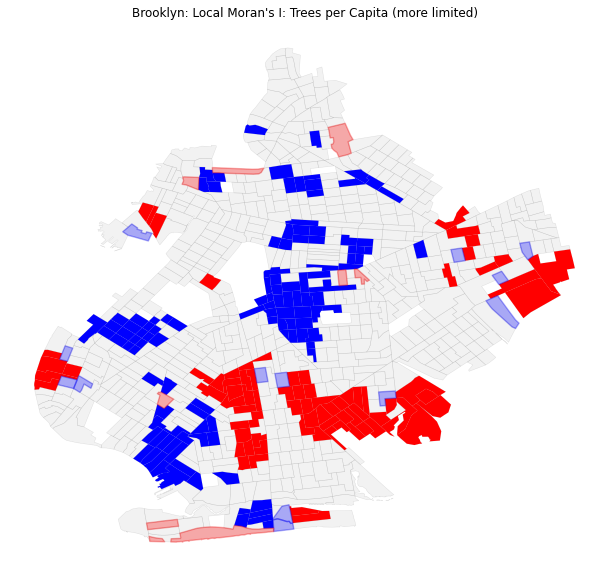

In [29]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_cap_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_cap_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Capita (more limited)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-Capita_more-limited.pdf")